# **Импорт библиотек**

In [1]:
import numpy as np 
import pandas as pd 
from pandas import Series

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score


import warnings
warnings.filterwarnings('ignore')

In [2]:
# визуальзация числовых признаков
def visual_num(col, size = 6):
    fig, (g1, g2) = plt.subplots(1, 2, figsize = (2*size,size))
    fig.suptitle('Histogram and boxplot for {0} '.format(col), fontsize=20)
    g1.hist(data[col], bins = 20, histtype = 'bar', align = 'mid', rwidth = 0.8, color = 'blue') # гистограмма
    g2.boxplot(data[col], vert = False)  # выбросы
    plt.figtext(0.5, 0, col, fontsize = 16)
    plt.show
    
# Поиск выбросов
def outliers(col):
    median = data[col].median()
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    l = perc25 - 1.5*IQR 
    r = perc75 + 1.5*IQR
    print("Для {0} IQR: {1}, ".format(col,IQR),"Границы выбросов: [{0}, {1}].".format(l, r))
    print('Всего {} выбросов'.format(data[data[col] > r][col].count() + data[data[col] < l][col].count()))


    
#Таблица метрик для сравнения результатов каждой модели
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'ROC_AUC']
summary = pd.DataFrame(index = metrics)
def summary_metrics(summary,col,y_valid,y_pred,y_pred_probs):
    values = [accuracy_score(y_valid,y_pred), precision_score(y_valid,y_pred), recall_score(y_valid,y_pred), f1_score(y_valid,y_pred), roc_auc_score(y_valid, y_pred_probs)]
    summary[col] = values
    return summary

# кривая ROC_AUC
def roc_auc_curve(y_valid, y_pred_probs):
    fpr, tpr, threshold = roc_curve(y_valid, y_pred_probs)
    roc_auc = roc_auc_score(y_valid, y_pred_probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

# Confusion matrix
def conf_mat(y_valid, y_pred):
    P = np.sum(y_valid==1)
    N = np.sum(y_valid==0)
    print('Positive: {0}, Negative: {1}'.format(P,N))
    
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    print(tp, fp) 
    print(fn, tn)

In [3]:
# Фиксируем RANDOM_SEED
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [4]:
# Импорт и просмотр данных
df_train = pd.read_csv('train1.csv')
df_test = pd.read_csv('test1.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print('df_train: ', df_train.shape)
display(df_train.head())
print('df_test: ', df_test.shape)
display(df_test.head())

df_train:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


df_test:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [5]:
# Для корректной обработки признаков объединяем тренировочный и тестовый датасеты в один датасет
df_train['sample'] = 1  # Помечаем где у нас трейн
df_test['sample'] = 0   # Помечаем где у нас тест
df_test['default'] = 0  # В тесте у нас нет значения default, поэтому мы его просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # Объединяем

In [6]:
# Проверяем результат
df.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
69062,19679,27JAN2014,SCH,F,62,N,N,0,0,-1.145250,1,50,2,3,9000,2,1,N,1,1
46221,8837,16JAN2014,SCH,M,29,N,N,0,0,-1.720003,3,40,1,2,46000,2,4,N,1,1
18854,14469,21JAN2014,GRD,F,49,N,N,0,0,-1.302849,1,80,2,3,50000,1,1,N,0,0
26896,13341,21JAN2014,UGR,M,22,N,N,0,1,-1.046854,0,80,2,3,60000,4,1,N,0,0
30303,51015,27FEB2014,SCH,F,46,N,N,0,0,-2.115448,1,40,1,2,35000,1,2,N,0,0


Описание признаков

* client_id - идентификатор клиента
* app_date - дата подачи заявки
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* score_bki - скоринговый балл по данным из БКИ
* bki_request_cnt - количество запросов в БКИ
* region_rating - рейтинг региона
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* foreign_passport - наличие загранпаспорта
* default - флаг дефолта по кредиту

# Обработка и очистка данных

In [7]:
# общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [8]:
df.isna().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

**Как мы видим, пропуски встречаются только в информации об образовании клиентов. Посмотрим на признак ближе:**

<AxesSubplot:>

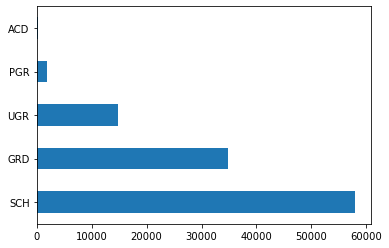

In [9]:
df['education'].value_counts().plot.barh()

**заменим пропуски в education наиболее часто встречающимся значением**

In [10]:
df['education'].fillna('SCH',  inplace = True)

In [11]:
# Проверяем результат
df.isna().sum()

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
sample              0
default             0
dtype: int64

**В датасете есть признак "app_date" - дата подачи заявки, имеющий тип "object". Преобразуем его в формат "datetime"**

In [12]:
df['app_date'] = pd.to_datetime(df.app_date)

In [13]:
# Проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         110148 non-null  int64         
 1   app_date          110148 non-null  datetime64[ns]
 2   education         110148 non-null  object        
 3   sex               110148 non-null  object        
 4   age               110148 non-null  int64         
 5   car               110148 non-null  object        
 6   car_type          110148 non-null  object        
 7   decline_app_cnt   110148 non-null  int64         
 8   good_work         110148 non-null  int64         
 9   score_bki         110148 non-null  float64       
 10  bki_request_cnt   110148 non-null  int64         
 11  region_rating     110148 non-null  int64         
 12  home_address      110148 non-null  int64         
 13  work_address      110148 non-null  int64         
 14  inco

In [14]:
# взглянем на диапазон дат
print(df['app_date'].min())
print(df['app_date'].max())

2014-01-01 00:00:00
2014-04-30 00:00:00


**Диапазон дат поданных заявок охватывает период за четыре месяца с начала года.**

**Преобразуем данный признак в число дней, прошедших с начала года (с момента подачи первой заявки**

In [15]:
# Запишем даты в отдельную переменную
date_app = df['app_date']

start_date = df['app_date'].min()  # Минимальное значение дат
df['app_date'] = df['app_date'].apply(lambda x: (x - start_date).days)  # Преобразование столбца

**Распределим наши данные на бинарные, категориальные и цифровые переменные**

In [16]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
num_cols = ['app_date', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

**Посмотрим на распределение числовых данных:**

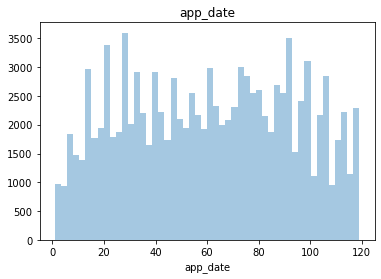

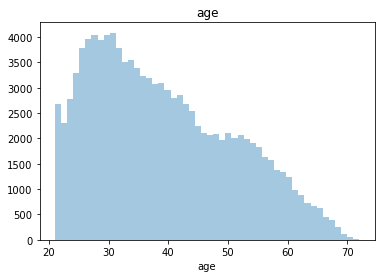

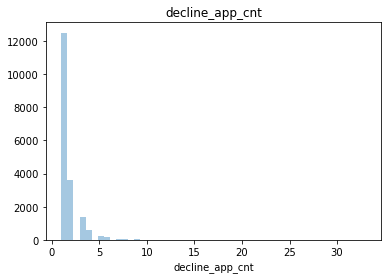

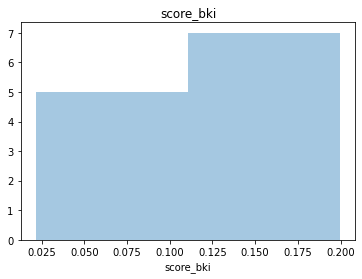

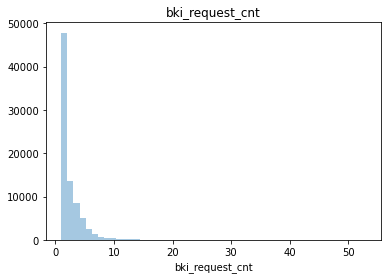

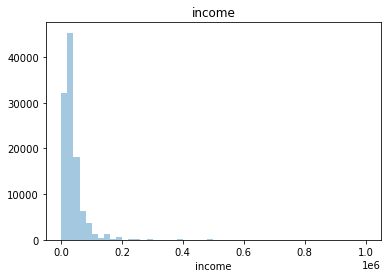

In [17]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

**После построения гистограмм стало очевидно, что распределения всех числовых переменных имеют "тяжёлый правый хвост".**
**Построим графики распределения логарифмированных переменных.**

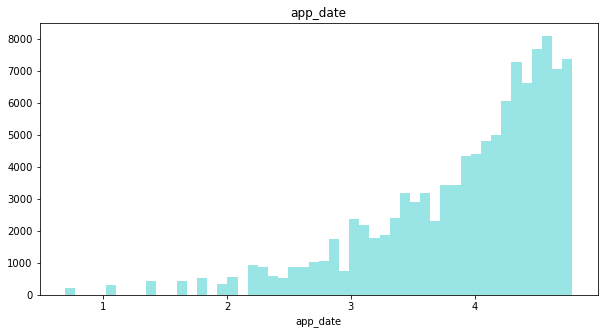

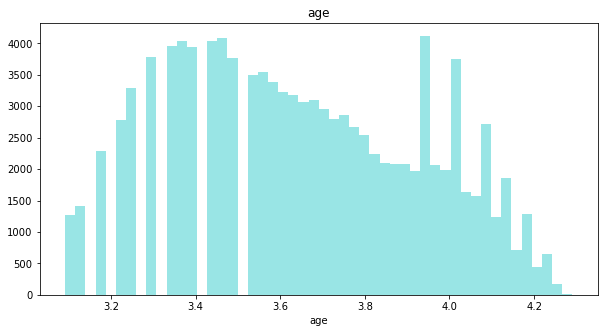

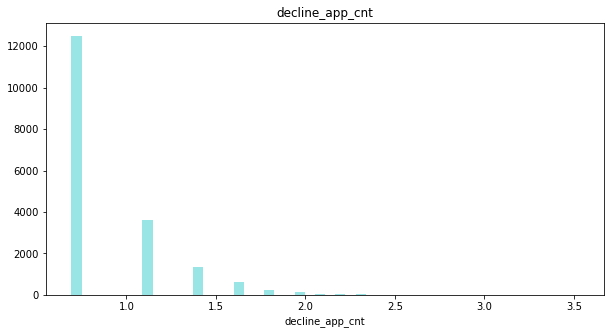

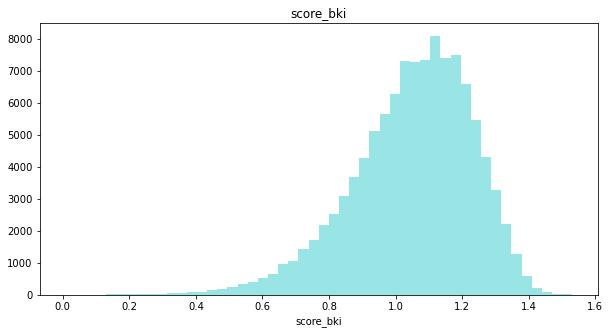

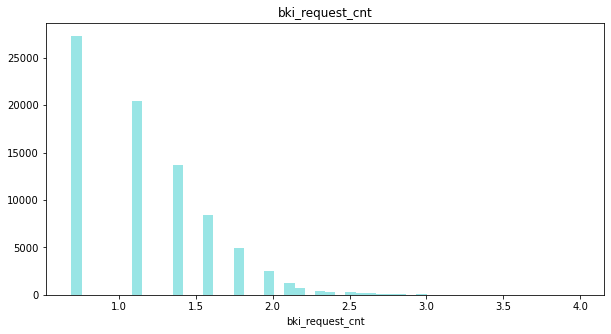

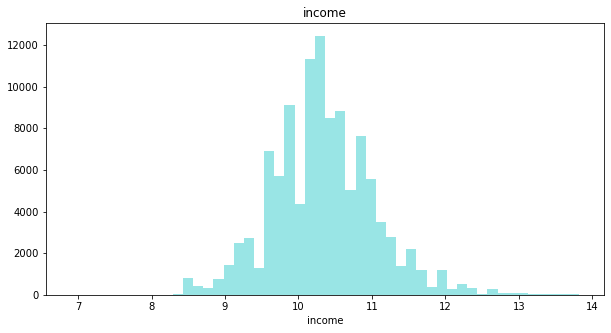

In [18]:
# Преобразуем все числовые переменные в логарифмические функции
for i in num_cols:
    df[i] = np.log1p(df[i].abs())
    plt.figure(figsize=(10,5))
    sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False, color='c')
    plt.title(i)
    plt.show()

**В распределении признаков "age" и "score_bki" произошло небольшое смещение вправо, распределение признака "income" стало нормальным**

**Построим boxplot’ы для численных переменных**

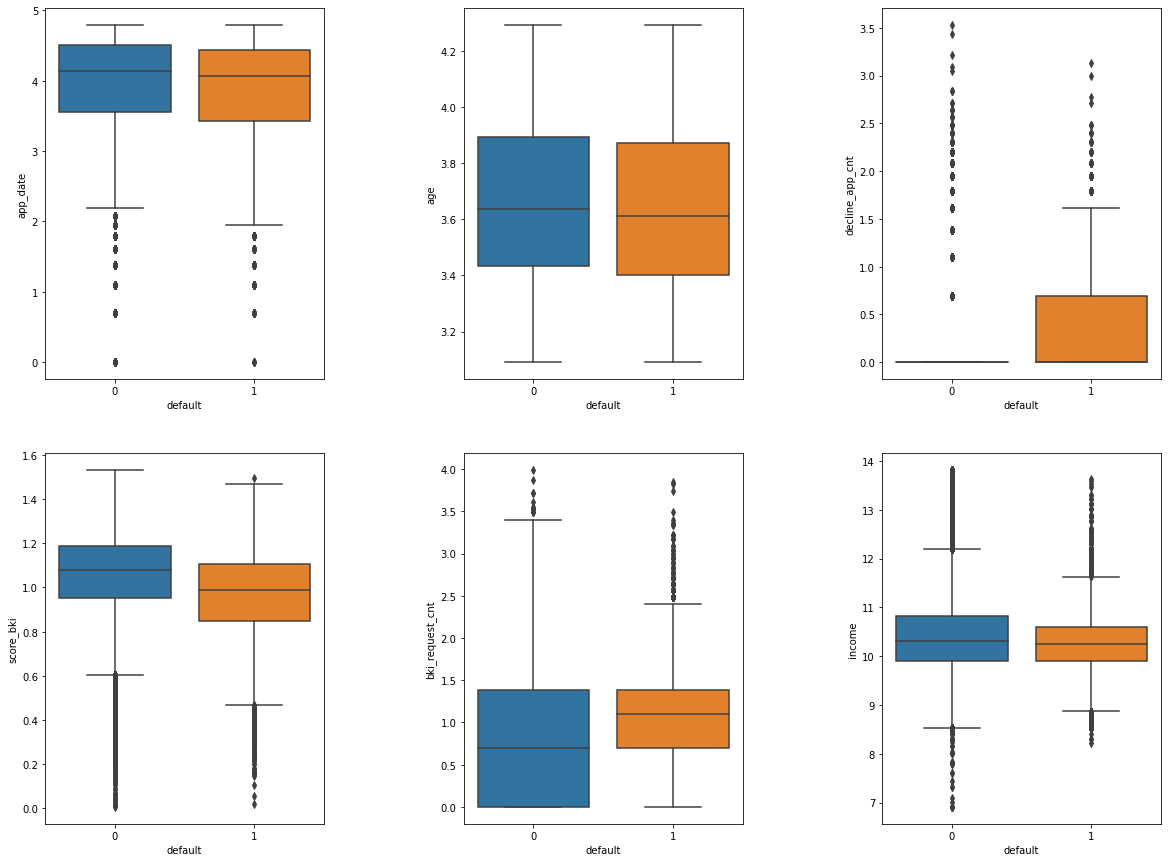

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(20,15))
plt.subplots_adjust(wspace = 0.5)
axes = axes.flatten()
for i in range(len(num_cols)):
    sns.boxplot(x="default", y=num_cols[i], data=df, orient = 'v', ax=axes[i], showfliers=True)

**На основании полученных графиков можно сделать выводы, что:**
* Пять числовых параметров имеют множественные выбросы
* Дефолтные клиенты в среднем немного младше недефолтных
* Дефолтные клиенты в среднем имеют немногим более низкий доход
* Дефолтные клиенты в среднем имеют бОльшее количество отмененных заявок
* Дефолтные клиенты в среднем имеют больше запросов в БКИ
* Дефолтные клиенты в среднем имеют более низкий в абсолютной величине скоринговый балл

<AxesSubplot:>

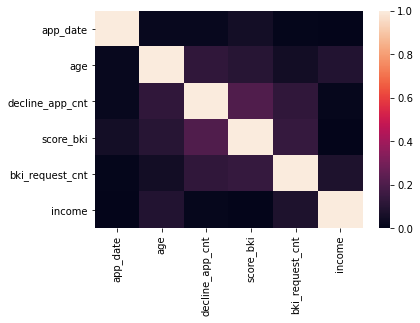

In [20]:
# Рассмотрим корреляцию цисловых признаков
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

**Очевиден вывод, что все признаки между собой слабо скоррелированы**

**Оставляем их все для дальнейшего построения модели**

**Выполним построение визуализации важности признаков с помощью функции f classif**

<AxesSubplot:>

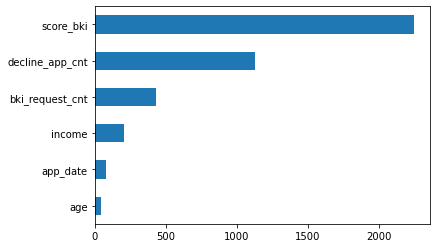

In [21]:
imp_num = Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# Выводы:
Из числовых признаков наибольшее влияние на целевую переменную оказывают признаки "score_bki" (скоринговый балл) и "decline_app_cnt" (количество отказов), наименьшее - "age" (возраст) и "app_date" (дата подачи заявки)

# Бинарные признаки

In [22]:
map_categories = {}  # Создаём словарь кодировок

label_encoder = LabelEncoder()

for column in bin_cols:  # Организуем цикл по бинарным признакам и создаем словарь
    df[column] = label_encoder.fit_transform(df[column])
    map_categories[column] = dict(enumerate(label_encoder.classes_)) 

In [23]:
# Проверяем  
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,4.394449,GRD,1,3.401197,1,1,0.000000,0,1.185366,1.386294,50,1,2,10.819798,1,4,0,0,0
1,17527,3.178054,SCH,0,3.688879,0,0,1.791759,0,0.918288,1.098612,50,1,2,8.517393,4,3,0,0,0
2,75683,4.406719,UGR,1,3.931826,1,1,0.000000,0,0.990039,0.693147,50,1,2,10.308986,1,3,1,0,0
3,26883,3.526361,SCH,1,4.043051,0,0,0.000000,0,1.216153,0.693147,40,1,2,9.741027,1,3,0,0,0
4,28862,3.555348,GRD,0,3.663562,0,0,0.000000,0,1.249186,0.000000,80,2,3,11.695255,1,3,0,0,0


# Категориальные признаки

In [24]:
# Для двух категориальных признаков: "education" и "region_rating" первоначальнор используем LabelEncoder
for name in ['education', 'region_rating']:
    df[name] = label_encoder.fit_transform(df[name])
    map_categories[name] = dict(enumerate(label_encoder.classes_))

**Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif**

<AxesSubplot:>

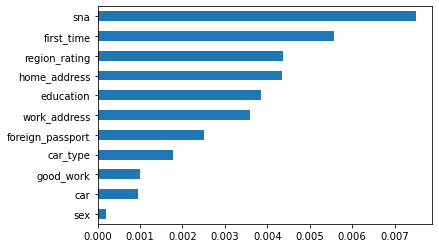

In [25]:
# посмотрим значимость признаков и бинарных и категориальных
imp_cat = Series(mutual_info_classif(df[df['sample']==1][bin_cols + cat_cols], df[df['sample']==1]['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

**Из категориальных признаков самыми значимыми являются признаки "sna" (связь заемщика с клиентами банка) и "first_time" (давность наличия информации о заемщике), наименее значимыми - "sex" (пол заёмщика)**

In [26]:
# заменим все категориальные признаки на dummy переменные

df = pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

In [27]:
df.head()

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,74835,4.394449,1,3.401197,1,1,0.000000,0,1.185366,1.386294,...,1,0,1,0,0,0,0,0,0,1
1,17527,3.178054,0,3.688879,0,0,1.791759,0,0.918288,1.098612,...,1,0,0,0,0,1,0,0,1,0
2,75683,4.406719,1,3.931826,1,1,0.000000,0,0.990039,0.693147,...,1,0,1,0,0,0,0,0,1,0
3,26883,3.526361,1,4.043051,0,0,0.000000,0,1.216153,0.693147,...,1,0,1,0,0,0,0,0,1,0
4,28862,3.555348,0,3.663562,0,0,0.000000,0,1.249186,0.000000,...,0,1,1,0,0,0,0,0,1,0


In [28]:
# удалим столбец client_id, т.к. по сути это просто порядковый номер
df = df.drop('client_id', axis=1)

# Подготовка данных к машинному обучению

In [29]:
# разделим снова на train_df и test_df
train_data = df[df['sample']== 1].drop(['sample'], axis=1)
test_data = df[df['sample']== 0].drop(['sample'], axis=1)

In [30]:
X = train_data.drop(['default'], axis=1).values
y = train_data['default'].values

In [31]:
# разделим на тренировочные и валидационные выборки
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

In [32]:
lr = LogisticRegression(random_state=RANDOM_SEED, max_iter = 1000)

In [33]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [34]:
probs = lr.predict_proba(X_valid)
y_pred_probs = probs[:,1]

y_pred = lr.predict(X_valid)

In [35]:
# посмотрим метрики
summary_metrics(summary,'model_1',y_valid,y_pred,y_pred_probs)

,model_1
accuracy,0.874661
precision,0.394495
recall,0.023536
f1_score,0.044421
ROC_AUC,0.743731


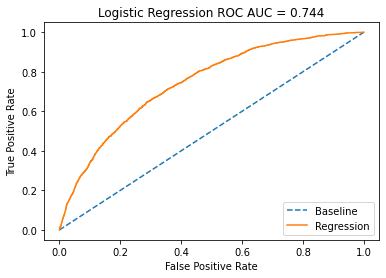

In [36]:
# построим кривую roc
roc_auc_curve(y_valid, y_pred_probs)

In [37]:
# и выведем confusion matrix
conf_mat(y_valid, y_pred)

Positive: 1827, Negative: 12933
43 66
1784 12867


**среди 1827 дефолтов наша модель предсказала только 42 и всех дефолтных клентов мы предсказали как не дефолтных, это ошибка первого рода**

**Попробуем улучшить модель, подобрав оптимальные параметры**

In [38]:
C = np.logspace(-1, 3, 10)
iter_ = 1000
epsilon_stop = 1e-3
 
hyperparameters = [
    {'penalty': ['l1'], 'C': C, 'max_iter':[iter_],'tol':[epsilon_stop]},
    {'penalty': ['l2'], 'C': C, 'max_iter':[iter_],'tol':[epsilon_stop]},
    {'penalty': ['none'], 'max_iter':[iter_],'tol':[epsilon_stop]},
]

model = LogisticRegression(class_weight = 'balanced', random_state = RANDOM_SEED)

In [39]:
# Обучаем модель
gridsearch = GridSearchCV(model, hyperparameters, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model_best_params = gridsearch.best_estimator_

# Печатаем параметры
best_params = model_best_params.get_params()
print(f'Лучшие значения параметров:') 
for param_name in best_params.keys():
        print(f'  {param_name} = {best_params[param_name]},')

Лучшие значения параметров:
  C = 0.2782559402207124,
  class_weight = balanced,
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 1000,
  multi_class = auto,
  n_jobs = None,
  penalty = l2,
  random_state = 42,
  solver = lbfgs,
  tol = 0.001,
  verbose = 0,
  warm_start = False,


In [40]:
# обучаем модель с подобранными параметрами
model_best_params = LogisticRegression(C = 0.2782559402207124,
                                       class_weight = 'balanced',
                                       dual = False,
                                       fit_intercept = True,
                                       intercept_scaling = 1,
                                       l1_ratio = None,
                                       max_iter = 1000,
                                       multi_class = 'auto',
                                       n_jobs = None,
                                       penalty = 'l2',
                                       random_state = 42,
                                       solver = 'lbfgs',
                                       tol = 0.001,
                                       verbose = 0,
                                       warm_start = False,)

In [41]:
model_best_params.fit(X_train, y_train)

LogisticRegression(C=0.2782559402207124, class_weight='balanced', max_iter=1000,
                   random_state=42, tol=0.001)

In [42]:
probs = model_best_params.predict_proba(X_valid)
y_pred_probs = probs[:,1]

y_pred = model_best_params.predict(X_valid)

In [43]:
# сравним метрики с предыдущей моделью
summary_metrics(summary,'second model',y_valid,y_pred,y_pred_probs)


,model_1,second model
accuracy,0.874661,0.673171
precision,0.394495,0.226900
recall,0.023536,0.681445
f1_score,0.044421,0.340443
ROC_AUC,0.743731,0.743404


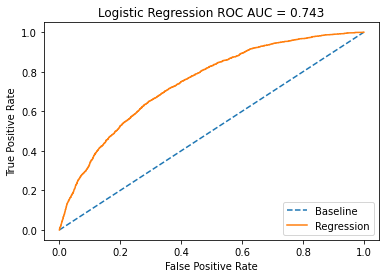

In [44]:
roc_auc_curve(y_valid, y_pred_probs)

In [45]:
conf_mat(y_valid, y_pred)

Positive: 1827, Negative: 12933
1245 4242
582 8691


#### Модель стала намного лучше предсказывать дефолтных клиентов, но хуже угадывать тех, кто не дефолтный.Попробуем применить Undersampling, чтобы сделать нашу выборку сбалансированной

#### Попробуем применить Undersampling, чтобы сделать нашу выборку сбалансированной

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [47]:
rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X, y)

In [48]:
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, test_size=0.10, shuffle = True, random_state=RANDOM_SEED)

In [49]:
model_us = LogisticRegression(C = 129.15496650148827,
                                      dual = False,
                                      fit_intercept = True,
                                      intercept_scaling = 1,
                                      l1_ratio = None,
                                      max_iter = 1000,
                                      multi_class = 'auto',
                                      n_jobs = None,
                                      penalty = 'l2',
                                      random_state = 42,
                                      solver = 'lbfgs',
                                      tol = 0.001,
                                      verbose = 0,
                                      warm_start = False)

In [50]:
model_us.fit(X_train_us, y_train_us)

LogisticRegression(C=129.15496650148827, max_iter=1000, random_state=42,
                   tol=0.001)

In [51]:
probs = model_us.predict_proba(X_test_us)
y_pred_probs = probs[:,1]

y_pred = model_us.predict(X_test_us)

In [52]:
# сравним метрики с предыдущей моделью
summary_metrics(summary,'model_us',y_test_us,y_pred,y_pred_probs)

,model_1,second model,model_us
accuracy,0.874661,0.673171,0.680000
precision,0.394495,0.226900,0.686047
recall,0.023536,0.681445,0.681723
f1_score,0.044421,0.340443,0.683878
ROC_AUC,0.743731,0.743404,0.750380


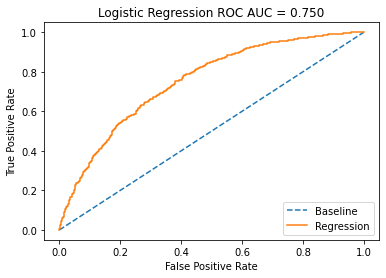

In [53]:
roc_auc_curve(y_test_us, y_pred_probs)

In [54]:
conf_mat(y_test_us, y_pred)


Positive: 952, Negative: 923
649 297
303 626


#### Видим, что у модели все метрики стали намного лучше. отпрааляем на submission

In [55]:
X_test = test_data.drop(['default'], axis=1)

In [56]:
y_pred_prob = model_us.predict_proba(X_test)[:,1]

In [57]:
submit = pd.DataFrame(df_test.client_id)
submit['default'] = y_pred_prob


In [58]:
submit.to_csv('submission_us.csv', index=False)

In [59]:
submit

,client_id,default
0,74835,0.205556
1,17527,0.760449
2,75683,0.286052
3,26883,0.406592
4,28862,0.145070
...,...,...
36344,83775,0.757073
36345,106254,0.139451
36346,81852,0.790032
36347,1971,0.604356
